In [1]:
from astropy.table import Table
from dendrocat import RadioSource
from astropy.io import fits
from spectral_cube import SpectralCube
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import numpy as np
import sys
import importlib
from astropy.wcs import WCS
from scipy import interpolate
import pandas as pd
import sympy as syp
from astropy import units as u
import radio_beam
from astropy.table import Table
from radio_beam import Beam
from astropy import coordinates
from astropy import wcs
from astropy.nddata.utils import Cutout2D
from dendrocat.aperture import Ellipse

W51 = '/orange/adamginsburg/w51/TaehwaYoo/'
W51b6 = '/orange/adamginsburg/w51/TaehwaYoo/2015.1.01596.S_W51_B6_LB/continuum_images/'
W51cont='/orange/adamginsburg/w51/TaehwaYoo/b6contfits/'
w51e2_b6_briggs=W51cont+'W51e2_cont_bigbriggs.image.fits'
w51e2_b6_robust0=W51cont+'W51e2_cont_big_robust0.image.fits'
w51e2_b6_uniform=W51cont+'W51e2_cont_biguniform.image.fits'
w51e2_b6_superuniform=W51cont+'W51e2_cont_bigsuperuniform.image.fits'

w51n_b6_briggs = W51cont+'W51n_cont_bigbriggs.image.fits'
w51n_b6_robust0 = W51cont+'w51n_cont_big_robust0.image.fits'
w51n_b6_uniform = W51cont+'W51n_cont_biguniform.image.fits'
w51n_b6_superuniform = W51cont+'W51n_cont_bigsuperuniform.image.fits'
w51n_b6_natural = W51cont+'W51n_cont_bignatural.image.fits'

W51b3 = '/orange/adamginsburg/w51/TaehwaYoo/2017.1.00293.S_W51_B3_LB/may2021_successful_imaging/'

w51n_b3_tt0 = W51b3+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51n_b3_tt1 = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51n_b3_alpha = W51+'w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51conv = '/orange/adamginsburg/w51/TaehwaYoo/convolved_new/'
w51n_b6_conv = w51conv + 'w51n_cont_bigbriggs.image.convB3_briggs.fits'

w51e2_b3_tt0 = W51b3+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'
w51e2_b3_tt1 = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt1.pbcor.fits'
w51e2_b3_alpha = W51+'w51e2.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.alpha.pbcor.fits'

w51e2_b6_conv = w51conv + 'w51e2_cont_bigbriggs.image.convB3_briggs.fits'

w51e_b6_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B6_conv.fits'
w51e_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51e_B3_conv.fits'


w51n_b3_almaimf_conv = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/w51n_B3_conv.fits'

w51n_b6_almaimf = '/orange/adamginsburg/w51/TaehwaYoo/w51_alma_imf/W51-IRS2_B6_uid___A001_X1296_X187_continuum_merged_12M_robust0_selfcal9_finaliter.image.tt0.pbcor.fits'

w51n_b6_conv_briggs = w51conv + 'w51n_briggs_B6_conv.fits'
w51n_b6_conv_robust0 = w51conv + 'w51n_robust0_B6_conv.fits'
w51n_b6_conv_superuniform = w51conv + 'w51n_superuniform_B6_conv.fits'


w51n_b6_conv_briggs = '/Users/dbahck37/w51data/convolved_new/w51n_briggs_B6_conv.fits'
w51n_b3_tt0 = '/Users/dbahck37/w51data/w51n.spw0thru19.14500.robust0.thr0.075mJy.mfs.I.startmod.selfcal7.image.tt0.pbcor.fits'




In [2]:
def measure_alpha_peak_matching(b3data, b6data, tb3, tb6, matchind,  save=True, savedir=None):
    peakx_b6 = list(tb6['peak_x'])
    peaky_b6 = list(tb6['peak_y'])
    peakxy_b6 = np.vstack((peakx_b6,peaky_b6)).T


    peakx_b3 = list(tb3['peak_x'])
    peaky_b3 = list(tb3['peak_y'])
    peakxy_b3 = np.vstack((peakx_b3,peaky_b3)).T

    fitsdata_b3 = fits.open(b3data)
    imageb3 = fitsdata_b3[0].data
    if len(imageb3.shape)!=2:
        imageb3 = imageb3[0][0]
    
    fitsdata_b6 = fits.open(b6data)
    imageb6 = fitsdata_b6[0].data
    if len(imageb6.shape)!=2:
        imageb6 = imageb6[0][0]

    hdrNB6 = fits.getheader(b6data)  
    hdrNB3 = fits.getheader(b3data)  
    wcsNB3 = WCS(hdrNB3,naxis=2)
    wcsNB6 = WCS(hdrNB6,naxis=2)
    
    my_beamNB6 = Beam.from_fits_header(hdrNB6)
    my_beamNB3 = Beam.from_fits_header(hdrNB3)


    scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
    scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]

    scaleNB3_sr = (scaleNB3 * np.pi/180)**2
    scaleNB6_sr = (scaleNB6 * np.pi/180)**2


    num_source = len(peakxy_b6)
    
    
    

    B6flux = get_flux(imageb6,peakxy_b6, my_beamNB6,  wcsNB6, num_source,scaleNB6)
    B3flux = get_flux(imageb3,peakxy_b3[matchind], my_beamNB3,  wcsNB3, num_source,scaleNB3)
  
    freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])

    freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])
    alpha = np.log10(B3flux/B6flux)/np.log10(freqb3/freqb6)
    print(alpha)
    
    return alpha

def get_flux(data,peakxy, beam1, wcsNB, num_source,pixel_scale, issky=False,savedir=None):
    fluxarr = []

    if issky:
        cen_world = peakxy
    else:
        cen_world = wcsNB.wcs_pix2world(peakxy,0)
    print('cen_world',cen_world)    
    for i in range(num_source):
        
        #x_cen = peakxy[i][0]
        #y_cen = peakxy[i][1]
        #cen = (x_cen, y_cen)
        major = beam1.major
        minor = beam1.minor
        pa = beam1.pa
        

        positions = coordinates.SkyCoord(cen_world[i,0],cen_world[i,1], frame=wcs.utils.wcs_to_celestial_frame(wcsNB).name,unit=(u.deg,u.deg))
        cutout = Cutout2D(data, positions, 4.0*major, wcs=wcsNB, mode='partial')
        frame = wcs.utils.wcs_to_celestial_frame(cutout.wcs).name
        aperture = Ellipse(positions, major, minor, -1*pa, unit=u.deg, frame=frame) # pa in degree with anti-clockwise direction
        this_mask = aperture.place(cutout.data, wcs=cutout.wcs)
        pixel_scale_sr = (pixel_scale.value * np.pi/180)**2 # pixel scale in deg^2 -> sr
        fluxarr.append(np.sum(cutout.data[this_mask]/beam1.sr.value*pixel_scale_sr)) # Jy/beam / (sr/beam) * (sr/pixel) = Jy/ pixel
        if savedir is not None:
            fig = plt.figure(figsize=(10,10))
            ax1=fig.add_axes([0.2,0.2,0.8,0.8],projection=wcsNB)
            ax1.imshow(cutout.data, origin='lower')
            ax1.imshow(this_mask, origin='lower',alpha=0.1,cmap='gray')
            plt.savefig(savedir+'aper_%04d.png'%i)
            plt.close()
    return np.array(fluxarr) 

def cen_freq(center, delta ,alpha=2):
    start = center-delta/2 ; end = center+delta/2
    freqarr = np.logspace(np.log10(start),np.log10(end),20)
    dfreq = freqarr[1:]-freqarr[:-1]
    dfreq = np.append(dfreq,[dfreq[-1]])
    
    integral_up = np.sum(freqarr**(alpha+1)*dfreq)
    integral_down = np.sum(freqarr**(alpha)*dfreq)
    return integral_up/integral_down






def alpha_from_skycoord_match(b3data, b6data, xpos, ypos, error=None, isb3=True):
  
    fitsdata_b3 = fits.open(b3data)
    imageb3 = fitsdata_b3[0].data
    if len(imageb3.shape)!=2:
        imageb3 = imageb3[0][0]
    
    fitsdata_b6 = fits.open(b6data)
    imageb6 = fitsdata_b6[0].data
    if len(imageb6.shape)!=2:
        imageb6 = imageb6[0][0]
        
  
    hdrNB6 = fits.getheader(b6data)  
    hdrNB3 = fits.getheader(b3data)  
    wcsNB3 = WCS(hdrNB3,naxis=2)
    wcsNB6 = WCS(hdrNB6,naxis=2)
    
    my_beamNB6 = Beam.from_fits_header(hdrNB6)
    my_beamNB3 = Beam.from_fits_header(hdrNB3)


    scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
    scaleNB6 = wcsNB6.proj_plane_pixel_scales()[0]
    
    if type(xpos) is not list:
        num_source = 1
    else:
        num_source = len(xpos)

    if isb3:
        peakxy_b3 = np.vstack((xpos,ypos)).T
        B3flux = get_flux(imageb3,peakxy_b3, my_beamNB3, wcsNB3, num_source,scaleNB3)
        if error is None:
            peaksky = wcsNB3.pixel_to_world(xpos,ypos)
            peaksky_ra = [] ; peaksky_dec = []
                
            for i in range(num_source):
                if num_source==1:
                    peaksky_ra.append(peaksky.ra.degree)
                    peaksky_dec.append(peaksky.dec.degree)
                else:
                    peaksky_ra.append(peaksky[i].ra.degree)
                    peaksky_dec.append(peaksky[i].dec.degree)
            peaksky_arr = np.vstack((peaksky_ra,peaksky_dec)).T
            B6flux = get_flux(imageb6,peaksky_arr, my_beamNB6, wcsNB6, num_source,scaleNB6,issky=True)
        else:
            B6flux = error
    else:
        peakxy_b6 = np.vstack((xpos,ypos)).T
        B6flux = get_flux(imageb6,peakxy_b6, my_beamNB6, wcsNB6, num_source,scaleNB6)
        if error is None:
            peaksky = wcsNB6.pixel_to_world(xpos,ypos)
            peaksky_ra = [] ; peaksky_dec = []
            for i in range(num_source):
                if num_source==1:
                    peaksky_ra.append(peaksky.ra.degree)
                    peaksky_dec.append(peaksky.dec.degree)
                else:
                    peaksky_ra.append(peaksky[i].ra.degree)
                    peaksky_dec.append(peaksky[i].dec.degree)
            peaksky_arr = np.vstack((peaksky_ra,peaksky_dec)).T
            B3flux = get_flux(imageb3,peakxy_arr, my_beamNB3, wcsNB3, num_source,scaleNB3,issky=True)
        else:
            B3flux = error
    freqb3 = cen_freq(hdrNB3['CRVAL3'],hdrNB3['CDELT4'])
    freqb6 = cen_freq(hdrNB6['CRVAL4'],hdrNB6['CDELT4'])
    alpha = np.log10(B3flux/B6flux)/np.log10(freqb3/freqb6)

    
    return alpha





[0, 1, 2, 3, 4, 7, 6, 8, 5, 9, 11, 10, 15, 13, 14, 16, 18, 19, 17, 20, 21]
[12]
[[290.91465206  14.5175986 ]
 [290.91495737  14.51782027]
 [290.91711257  14.51789417]
 [290.91590742  14.51800889]
 [290.91550972  14.51810027]
 [290.91595563  14.51814111]
 [290.9161826   14.51812556]
 [290.91563426  14.51811   ]
 [290.91647987  14.51815083]
 [290.91687556  14.51818972]
 [290.91606007  14.51816639]
 [290.91679722  14.51815861]
 [290.91693783  14.51817417]
 [290.9155981   14.51821305]
 [290.91680124  14.51821694]
 [290.9170021   14.51825194]
 [290.91707441  14.51823444]
 [290.91715274  14.51827139]
 [290.91660641  14.51825194]
 [290.91707441  14.51826556]
 [290.91662248  14.51828306]
 [290.91665462  14.51836472]]
1.834915743934e-05 deg


(array([1., 1., 0., 4., 2., 1., 6., 2., 3., 1.]),
 array([-0.046108  , -0.02108838,  0.00393125,  0.02895087,  0.05397049,
         0.07899012,  0.10400974,  0.12902936,  0.15404899,  0.17906861,
         0.20408824]),
 <BarContainer object of 10 artists>)

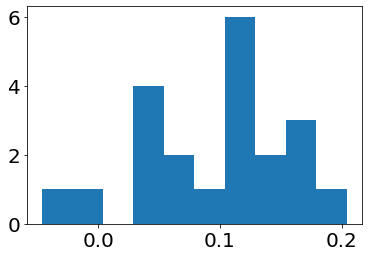

In [3]:
plt.rcParams['axes.labelsize']=20
plt.rcParams['xtick.labelsize']=20
plt.rcParams['ytick.labelsize']=20
plt.rcParams['axes.titlesize']=20
#w51n_b3 = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51n_b3.fits',format='fits')
#w51n_b6 = Table.read('/home/t.yoo/w51/catalogue/dendrogram/dendro_w51n_b6_briggs.fits',format='fits')
w51n_b3 = Table.read('/Users/dbahck37/w51_jupyter/w51/catalogue/dendrogram/dendro_w51n_b3.fits',format='fits')
w51n_b6 = Table.read('/Users/dbahck37/w51_jupyter/w51/catalogue/dendrogram/dendro_w51n_b6_briggs.fits',format='fits')
b6matind = w51n_b6['matching_index']
indic = w51n_b3['_name']
matchindlist = []
for ind in b6matind:
    matchind = np.where(ind==indic)[0]
    matchindlist.append(matchind[0])
print(matchindlist)

# find unselected index
unselected = list(np.arange(len(indic)))
for ind in matchindlist:
    unselected.remove(ind)
print(unselected)

hdrNB6 = fits.getheader(w51n_b6_conv_briggs)  
hdrNB3 = fits.getheader(w51n_b3_tt0)  
wcsNB3 = WCS(hdrNB3,naxis=2)
wcsNB6 = WCS(hdrNB6,naxis=2)


peakx_b6 = list(w51n_b6['peak_x'])
peaky_b6 = list(w51n_b6['peak_y'])
peakxy_b6 = np.vstack((peakx_b6,peaky_b6)).T

cen_world_b6 = wcsNB6.wcs_pix2world(peakxy_b6,0)


peakx_b3 = list(w51n_b3['peak_x'])
peaky_b3 = list(w51n_b3['peak_y'])
peakxy_b3 = np.vstack((peakx_b3,peaky_b3)).T

cen_world_b3 = wcsNB3.wcs_pix2world(peakxy_b3,0)
print(cen_world_b3)
radiff = cen_world_b6[:,0] - cen_world_b3[matchindlist,0]
decdiff = cen_world_b6[:,1] - cen_world_b3[matchindlist,1]

my_beamNB3 = Beam.from_fits_header(hdrNB3)
print(my_beamNB3.major)
#b3tob6ind=np.array([0,1,2,3,4,5,8,7,9,6,10,11,12,13,14,16,17,18,15,20,19,21])
plt.hist(radiff/my_beamNB3.major.value)



(array([2., 1., 0., 2., 3., 9., 2., 0., 1., 1.]),
 array([0.01513045, 0.04540463, 0.0756788 , 0.10595298, 0.13622716,
        0.16650133, 0.19677551, 0.22704968, 0.25732386, 0.28759804,
        0.31787221]),
 <BarContainer object of 10 artists>)

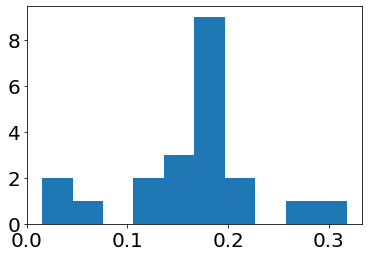

In [4]:
plt.hist(decdiff/my_beamNB3.major.value)

cen_world [[290.91465409  14.51760138]
 [290.91495968  14.5178236 ]
 [290.91711316  14.51789722]
 [290.91590658  14.5180125 ]
 [290.9155106   14.51810416]
 [290.91563685  14.5181125 ]
 [290.91618347  14.51812917]
 [290.91648189  14.51815417]
 [290.91595823  14.51814444]
 [290.9168793   14.51819306]
 [290.9168004   14.51816111]
 [290.91606009  14.51817222]
 [290.91700412  14.51825278]
 [290.91560098  14.51821389]
 [290.91680326  14.51822083]
 [290.91707586  14.5182375 ]
 [290.91660815  14.51825694]
 [290.91707586  14.51826806]
 [290.91715477  14.51827361]
 [290.91662536  14.51828333]
 [290.91665549  14.51836806]]
cen_world [[290.91465206  14.5175986 ]
 [290.91495737  14.51782027]
 [290.91711257  14.51789417]
 [290.91590742  14.51800889]
 [290.91550972  14.51810027]
 [290.91563426  14.51811   ]
 [290.9161826   14.51812556]
 [290.91647987  14.51815083]
 [290.91595563  14.51814111]
 [290.91687556  14.51818972]
 [290.91679722  14.51815861]
 [290.91606007  14.51816639]
 [290.9170021   14.518

Text(0.5, 0, 'alpha')

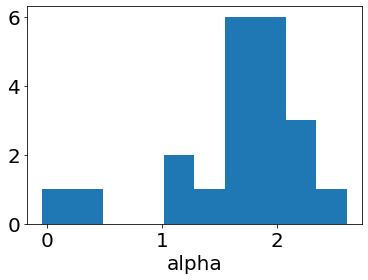

In [5]:

alpha = measure_alpha_peak_matching(w51n_b3_tt0, w51n_b6_conv_briggs,w51n_b3,w51n_b6, matchindlist)
plt.hist(alpha)
plt.xlabel('alpha')



In [6]:
def save_matched_catalog(b3data,b6data,peakx_b3,peaky_b3,
                         peakx_b6,peaky_b6,alpha,
                         unselected,matchindlist):
    if len(unselected)==1:
        unselected = unselected[0]
    
    xpos_unselected = peakx_b3[unselected] 
    ypos_unselected = peaky_b3[unselected]

    x_pix_b3 = np.array(peakx_b3)[matchindlist]
    x_pix_b3 = list(x_pix_b3)
    x_pix_b3.append(xpos_unselected)

    y_pix_b3 = np.array(peaky_b3)[matchindlist]
    y_pix_b3 = list(y_pix_b3)
    y_pix_b3.append(ypos_unselected)

    xy_pix_b3 = np.vstack((x_pix_b3,y_pix_b3)).T
    xy_sky_b3 = wcsNB3.wcs_pix2world(xy_pix_b3,0)
    x_sky_b3 = xy_sky_b3[:,0]
    y_sky_b3 = xy_sky_b3[:,1]
    

    x_pix_b6 = peakx_b6
    y_pix_b6 = peaky_b6

    xy_pix_b6 = np.vstack((x_pix_b6,y_pix_b6)).T
    xy_sky_b6 = wcsNB6.wcs_pix2world(xy_pix_b6,0)
    
    x_pix_b6 = list(x_pix_b6)
    x_pix_b6.append(-99)
    y_pix_b6 = list(y_pix_b6)
    y_pix_b6.append(-99)
    
    x_sky_b6 = xy_sky_b6[:,0]
    y_sky_b6 = xy_sky_b6[:,1]
    x_sky_b6 = list(x_sky_b6)
    x_sky_b6.append(-99)
    y_sky_b6 = list(y_sky_b6)
    y_sky_b6.append(-99)
    





    alpha_unselected = alpha_from_skycoord_match(b3data,b6data, xpos_unselected, ypos_unselected, error=None, isb3=True)
    alpha = list(alpha)
    if len(alpha_unselected)==0:
        alpha_unselected = alpha_unselected[0][0]
    print(alpha_unselected)
    alpha.append(alpha_unselected[0])

    table_matched = Table([x_sky_b3,y_sky_b3,x_sky_b6,y_sky_b6,
                           x_pix_b3,y_pix_b3,x_pix_b6,y_pix_b6,
                           alpha],
                          names=['x_sky_b3','y_sky_b3','x_sky_b6','y_sky_b6',
                                         'x_pix_b3','y_pix_b3','x_pix_b6','y_pix_b6',
                                         'alpha'])
    
    table_matched.write('w51n_catalog.fits',format='fits')
    return table_matched
    #


ta_cat = save_matched_catalog(w51n_b3_tt0,w51n_b6_conv_briggs,peakx_b3,peaky_b3,
                         peakx_b6,peaky_b6,alpha,
                         unselected,matchindlist)

cen_world [[290.91693783  14.51817417]]
cen_world [[290.91693783  14.51817417]]
[1.1812047]


x_pix_b3
--------
    8253
    8101
    7028
    7628
    7826
    7764
    7491
    7343
    7604
    7146
    7185
    7552
    7083
    7782
    7183
    7047
    7280
    7047
    7008
    7272
    7256
    7115 y_pix_b3
--------
    7015
    7129
    7167
    7226
    7273
    7278
    7286
    7299
    7294
    7319
    7303
    7307
    7351
    7331
    7333
    7342
    7351
    7358
    7361
    7367
    7409
    7311    alpha    
------------
   2.3266203
   1.5724385
  0.27592242
-0.044980038
   2.0066051
   2.3262732
   2.0774536
   1.7093251
   2.0133083
   1.7544961
   1.8568474
   2.0624218
    2.611094
   1.5578319
   2.1760108
   1.2331492
    2.041058
   1.1366687
   1.6081278
   1.5448232
    1.804642
   1.1812047


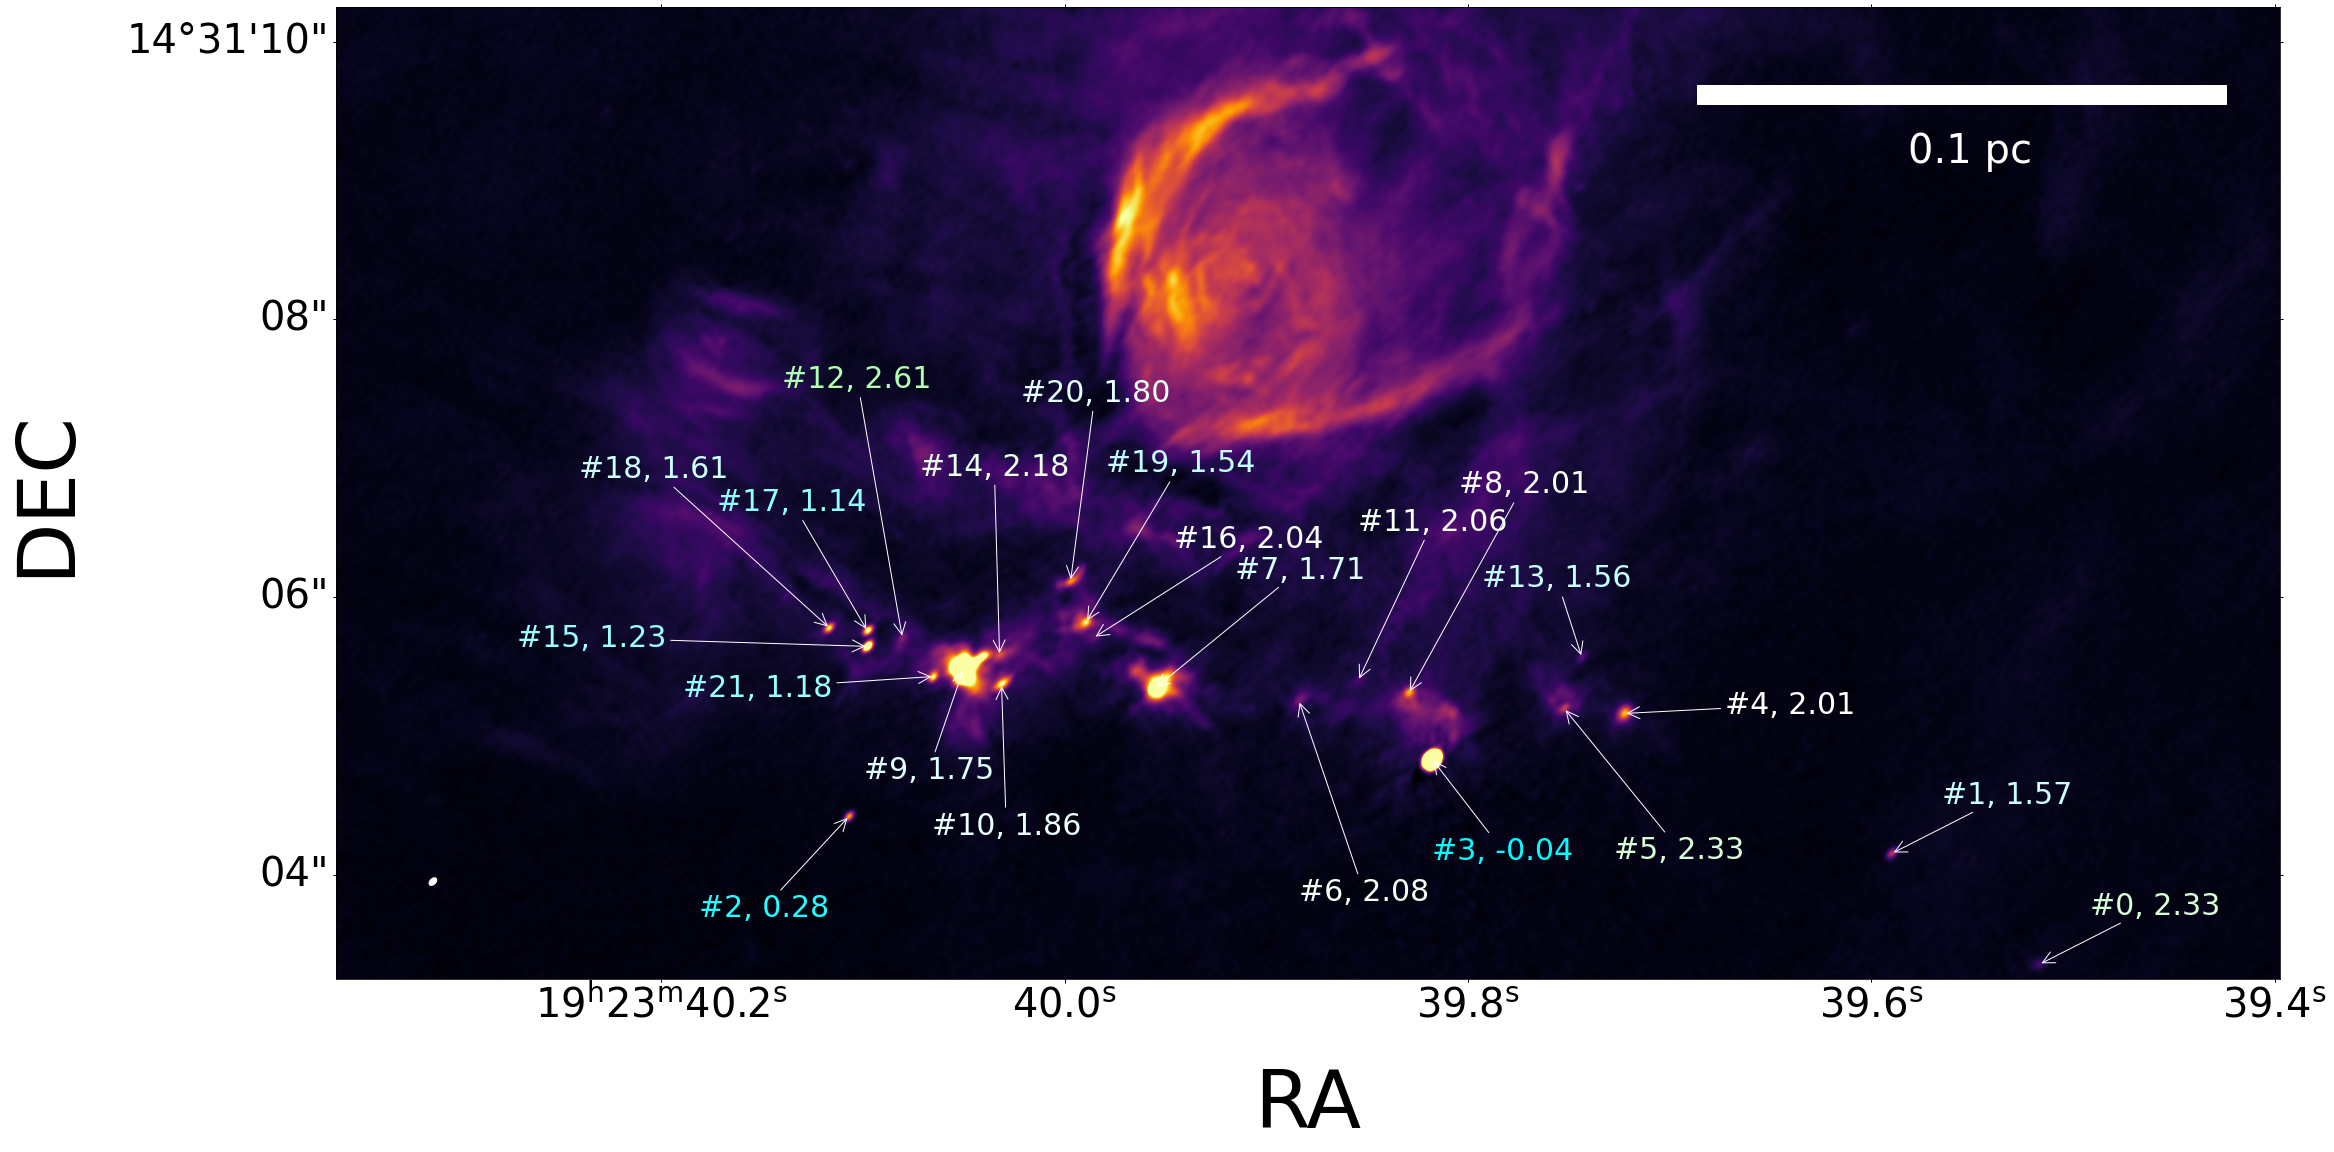

In [7]:
plt.rcParams['axes.labelsize']=80
plt.rcParams['xtick.labelsize']=40
plt.rcParams['ytick.labelsize']=40
plt.rcParams['axes.titlesize']=80
import matplotlib as mpl 
import matplotlib.cm as cm
import matplotlib.colors
from matplotlib.patches import Rectangle, Ellipse

def plot_peak(ax,image,xpos,ypos,size=20,labelind=None,labeltext=None,xtextpos=None,ytextpos=None,mark=False):
    cmap = cm.YlGn
    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ['cyan',"w","lime"])
    norm = mpl.colors.Normalize(vmin=0, vmax=4)
    
    
    if mark:
        ax.scatter(xpos,ypos, marker='x', c='cyan',s=size)
    m = cm.ScalarMappable(norm=norm, cmap=cmap)
    for i in range(len(labelind)):
        ax.annotate("#%d, %3.2f"%(i,labelind[i]),xy=(xpos[i],ypos[i]), xycoords='data', textcoords='offset pixels',
                    arrowprops=dict(arrowstyle="->",ec='w',fc='w'),xytext=(xtextpos[i],ytextpos[i]),fontsize=30,color=m.to_rgba(labelind[i]))
    
    
def add_scale_bar(ax, xpos,ypos,scale, pixel_scale, dist, unit='pc',height=20,color='w',pad=40,size=40):
    phy_pix_scale = pixel_scale.value * np.pi/180 * dist
    ax.add_patch(Rectangle((xpos,ypos),scale/phy_pix_scale,height,color=color))
    ax.text(xpos+0.4*scale/phy_pix_scale, ypos+pad, '%2.1f %s'%(scale, unit), color=color,fontsize=size)
                
def add_beam(ax,xpos,ypos,beam, pixel_scale,color='w'):
    width = beam.major / pixel_scale
    height = beam.minor /pixel_scale
    angle = beam.pa
    ax.add_patch(Ellipse((xpos,ypos),width.value,height.value,180-angle.value,color=color))

xtextpos = [50, 50, -150,    0,  100,   
            50,    0,  80,   50,  -100,  
            -70,     0,   -120, -100, -80,  
            -350, 80,  -150, -250, 20, 
            -50, -250]
ytextpos = [50, 50, -100, -100,    0, 
            -150, -200, 110,  200,  -110, 
            -150, 150, 250, 70, 180,
            0,  90, 120,  150, 150,
            180, -20]
    
fitsdata_b3 = fits.open(w51n_b3_tt0)
hdrNB3 = fits.getheader(w51n_b3_tt0)  
wcsNB3 = WCS(hdrNB3,naxis=2)
scaleNB3 = wcsNB3.proj_plane_pixel_scales()[0]
fig = plt.figure(figsize=(30,30))
ax1 = fig.add_axes([0.1,0.1,0.9,0.9],projection=wcsNB3)
imageb3 = fitsdata_b3[0].data[0][0]
ax1.imshow(imageb3, origin='lower',cmap=plt.get_cmap('inferno'),vmin=-0.000055507826955594655,vmax=0.002191274995850258)
#mark_dendrogram_results(ax1, image, source_object,custom_dendro,
#                           vmin=-0.00044910456346381985,vfmax=0.006639306914117084)
#mark_dendrogram_results(ax1, imageb3_cut, source_object_b3,custom_dendro_b3
#                           ,vmin=-0.00044910456346381985,vmax=0.006639306914117084)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True,rejectreject=False)
#draw_sources_ellipses(ax1,wcs,source_object.pixel_scale,source_object,lw=1,markname=True)

xpos = ta_cat['x_pix_b3']
ypos = ta_cat['y_pix_b3']
alpha = ta_cat['alpha']
print(xpos,ypos,alpha)
plot_peak(ax1,imageb3,xpos,ypos,size=40,labelind=alpha,xtextpos=xtextpos,ytextpos=ytextpos)
ax1.set_xlabel('RA')
ax1.set_ylabel('DEC')
ax1.set_xlim(6500,8500)
ax1.set_ylim(7000,8000)
my_beamNB3 = Beam.from_fits_header(hdrNB3)
add_scale_bar(ax1, 7900,7900,0.1,scaleNB3,5.41e3,pad=-60)
add_beam(ax1,6600,7100,my_beamNB3, scaleNB3)
plt.savefig('dendroimage_w51n.png')

plt.show()


In [8]:

skycoord1 = wcsNB3.pixel_to_world(6500,7000)
skycoord2 = wcsNB3.pixel_to_world(8500,8000)
print(skycoord1,skycoord2)



<SkyCoord (ICRS): (ra, dec) in deg
    (290.9181731, 14.51756944)> <SkyCoord (ICRS): (ra, dec) in deg
    (290.91415592, 14.51951388)>
